#### BV-NICE Demo code

In [1]:
import os
import sys
from time import time

import numpy as np
import tensorflow as tf
import pandas as pd
import math

import matplotlib.pyplot as plt
%matplotlib inline

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement=True
sess = tf.Session(config=config)

In [2]:
# NORM = True  # 

# VAL = True  # 

lam = 1 # imbalance parameter (i.e., regularzation for the KL-matching)
# lam = 0.

zeta = 1. # match aggregated posterior dist to the prior distribution
# zeta = 0

ihdp_id = 0

eta = .1  # noise level
# eta = 0.

alph = 0. # representation regularization
# alph = 1e-5   

kappa = .01  # propensity score weight
# kappa = 0.

RDECOMP = True # to use Robinson decomposition
# RDECOMP = False

In [3]:
class flags:
    
    x_dim = 25
    y_dim = 1
    t_dim = 2
    
    hidden_units = 64
    
    hidden_size = 2
    
    xi_dim = 10
    
    batch_size = 128 # Batch size during training 
    
    
FLAGS = flags()
args = FLAGS

DTYPE = tf.float32

In [4]:
def onehot(t,dim):
    
    m_samples = t.shape[0]
    tt = np.zeros([m_samples,dim])
    
    for i in range(m_samples):
        tt[i,np.int(t[i])] = 1
        
    return tt

In [ ]:
initializer = tf.contrib.layers.xavier_initializer()
# initializer = None

nonlinearity=tf.nn.relu

def critic(z,x,name):
    
    hidden_units = FLAGS.hidden_units    # size of hidden units in a layer
    
    if x is None:
        input_tensor = z;
    else:
        input_tensor = tf.concat([x,z],axis=-1)
    
    with tf.variable_scope('critic-%s' % name,reuse=tf.AUTO_REUSE):
        h1 = tf.layers.dense(input_tensor,hidden_units,kernel_initializer=initializer,activation=nonlinearity)
        h2 = tf.layers.dense(h1,hidden_units,kernel_initializer=initializer,activation=nonlinearity)
        # h2 = tf.layers.dense(h2,hidden_units,kernel_initializer=initializer,activation=nonlinearity)
        # o = tf.layers.dense(h2,1,activation=None)
        o = tf.layers.dense(h2,1,kernel_initializer=initializer,activation=tf.nn.tanh)
        o *= 5
        
    return o;

def simple_mlp(x,out_dim,name):
    
    hidden_units = FLAGS.hidden_units   # size of hidden units in a layer
    
    input_tensor = x
    
    with tf.variable_scope('%s' % name,reuse=tf.AUTO_REUSE):
        h1 = tf.layers.dense(input_tensor,hidden_units,kernel_initializer=initializer,activation=nonlinearity)
        h2 = tf.layers.dense(h1,hidden_units,kernel_initializer=initializer,activation=nonlinearity)
        o = tf.layers.dense(h2,out_dim,kernel_initializer=initializer,activation=None)
        
    return o;

In [6]:
# def encoder(input_x,input_y,input_t,name='encoder'):
#     '''
#     approximate posterior of z given x,y,t
#     p(z|x,y,t)
#     return mean and var of z
    
#     '''
    
#     if (input_y is not None) and (input_t is not None):
#         input_tensor = tf.concat([input_x,input_y,input_t],axis=-1)  # cbind 
#     else:
#         input_tensor = input_x
    
#     hidden_units = FLAGS.hidden_units   # size of hidden units in a layer
    
#     with tf.variable_scope(name,reuse=tf.AUTO_REUSE):
#         h1 = tf.layers.dense(input_tensor,hidden_units,kernel_initializer=initializer,activation=nonlinearity)
#         h2 = tf.layers.dense(h1,hidden_units,kernel_initializer=initializer,activation=nonlinearity)
#         o = tf.layers.dense(h2,FLAGS.hidden_size,kernel_initializer=initializer,activation=None)
#         # o = tf.layers.dense(h2,2*latent_size,activation=None,use_bias=False)
    
#     return o

In [7]:
def estimate_causal_effect(xx, n_runs=1):
    
    m_samples = xx.shape[0]
    
    t0 = np.zeros([m_samples,FLAGS.t_dim]); t0[:,0] = 1;
    t1 = np.zeros([m_samples,FLAGS.t_dim]); t1[:,1] = 1;
    mu0_hat = estimate_outcome(xx, t0, n_runs)
    mu1_hat = estimate_outcome(xx, t1, n_runs)
    
    tau_hat = mu1_hat - mu0_hat
    
#     tau_hat = 0
#     for i in range(n_runs):
#         t0 = np.zeros([m_samples,FLAGS.t_dim]); t0[:,0] = 1;
#         t1 = np.zeros([m_samples,FLAGS.t_dim]); t1[:,1] = 1;

#         mu0_hat = tf_eval(y_hat,m_samples,{input_x: xx, input_t: t0})
#         mu1_hat = tf_eval(y_hat,m_samples,{input_x: xx, input_t: t1})

#         tau_hat += mu1_hat - mu0_hat
    
#     tau_hat /= n_runs
    
    return tau_hat

def estimate_outcome(xx, tt, n_runs=1):
    m_samples = xx.shape[0]
    
    y_t_hat = 0
    
    for i in range(n_runs):

        y_t_hat = tf_eval(y_hat,m_samples,{input_x: xx, input_t: tt})
    
    y_t_hat /= n_runs
    
    return y_t_hat

In [8]:
def int_shape(x):
    return list(map(int, x.get_shape()))

def print_shape(x,varname='variable'):
    if x is None:
        print('%s size: None' % (varname))
        return
    x_shape = x.shape.as_list()
    # print('%s size: [%d,%d,%d]' % (varname,x_shape[1],x_shape[2],x_shape[3]))
    print(varname,end=': ')
    print(x_shape)

def tf_eval(tf_tensor,n_samples,feed_dict=None):
    
    MLOOP = np.int(np.ceil(n_samples/FLAGS.batch_size))
    
    dd = tf_tensor.shape.as_list()[1:]
    dd.insert(0,n_samples)
    
    x = np.zeros(dd)
    
    for mloop in range(MLOOP):
        
        st = mloop*FLAGS.batch_size
        ed = min((mloop+1)*FLAGS.batch_size, n_samples)
        
        if feed_dict is not None:
            feed_dict_i = dict()
            for key in feed_dict.keys():
                feed_dict_i[key] = np.random.randn(*int_shape(key))
                feed_dict_i[key][:ed-st] = feed_dict[key][st:ed]
            y = sess.run(tf_tensor,feed_dict=feed_dict_i)
        else:
            y = sess.run(tf_tensor)
        
        # print([st,ed])
        x[st:ed] = y[:ed-st]
    
    return x

def tf_eval_list(tf_tensor_list,n_samples,feed_dict=None):
    
    if isinstance(tf_tensor_list, list)==False:
        print('Input not a list')
        return None
    
    MLOOP = np.int(np.ceil(n_samples/FLAGS.batch_size))
    
    res = dict()

    for key in tf_tensor_list:
        dd = key.shape.as_list()[1:]
        dd.insert(0,n_samples)
        res[key] = np.zeros(dd)
    
    for mloop in range(MLOOP):
        
        st = mloop*FLAGS.batch_size
        ed = min((mloop+1)*FLAGS.batch_size,n_samples)
        
        if feed_dict is not None:
            feed_dict_i = dict()
            for key in feed_dict.keys():
                feed_dict_i[key] = np.random.randn(*int_shape(key))
                feed_dict_i[key][:ed-st] = feed_dict[key][st:ed]
            # print(feed_dict_i)
            y = sess.run(tf_tensor_list,feed_dict=feed_dict_i)
        else:
            y = sess.run(tf_tensor_list)
        
        for i in range(len(tf_tensor_list)):
            res[tf_tensor_list[i]][st:ed] = y[i][:ed-st]
    
    return res

In [9]:
def eval_pehe(tau_hat,tau):
    return np.sqrt(np.mean(np.square(tau-tau_hat)))

In [10]:
def load_ihdp(trial_id=0,filepath='./data/',istrain=True):
    
    if istrain:
        data_file = filepath+'ihdp_npci_1-1000.train.npz'
    else:
        data_file = filepath+'ihdp_npci_1-1000.test.npz'
        
    data = np.load(data_file)
    
    x = data['x'][:,:,trial_id]
    y = data['yf'][:,trial_id]
    t = data['t'][:,trial_id]
    ycf = data['ycf'][:,trial_id]
    mu0 = data['mu0'][:,trial_id]
    mu1 = data['mu1'][:,trial_id]
    
    return x,y,t,ycf,mu0,mu1

In [11]:
# Loading normalized IHDP example
data = np.load('ihdp_example.npy',allow_pickle=True).item()
X = data['X'] # Confounder proxiess
Y = data['Y'] # Factual outcomes
T = data['T'] # Treatment
Tau = data['Tau']  # Ground truth ITE

n_samples = X.shape[0]

In [12]:
t1_ind = T[:,1]==1   # find which column has the treatment == 1
t0_ind = T[:,0]==1 

n0 = np.sum(t0_ind)
n1 = np.sum(t1_ind)

X0 = X[t0_ind]
X1 = X[t1_ind]

Y0 = Y[t0_ind]
Y1 = Y[t1_ind]

In [13]:
def get_phi_x(input_x):
    xi = tf.random.uniform([FLAGS.batch_size,FLAGS.xi_dim], minval=-1,maxval=1)
    x_xi = tf.concat([input_x,eta*xi],axis=-1)
    phi_x = simple_mlp(x_xi,FLAGS.hidden_size,name='encoder')
    return phi_x

In [ ]:
# Model specification

input_x = tf.placeholder(tf.float32, shape=[FLAGS.batch_size, FLAGS.x_dim])
input_t = tf.placeholder(tf.int32, shape=[FLAGS.batch_size, FLAGS.t_dim])
input_y = tf.placeholder(tf.float32, shape=[FLAGS.batch_size, FLAGS.y_dim])

phi_x = get_phi_x(input_x)

In [ ]:
# Propensity score

logit_t_x = simple_mlp(phi_x, 2, 'predictor_ps') # propensity score
e_x = tf.reshape(tf.nn.softmax(logit_t_x)[:,1],[-1,1])

loss_e_x_vec = tf.nn.softmax_cross_entropy_with_logits(labels=input_t, logits=logit_t_x)
loss_e_x = tf.reduce_mean(loss_e_x_vec)


if RDECOMP:
    # Robinson decomposition
    
    print('Use Robinson decomposition')
    
    m_x = simple_mlp(phi_x, 1, 'predictor_m') # expected outcome 
    tau_x = simple_mlp(phi_x, 1, 'predictor_tau') # causal effect
    
    # Continuous outcome
    input_t_bin = tf.reshape(tf.cast(input_t[:,1],dtype=tf.float32),[-1,1])
    y_hat = m_x + (tf.cast(input_t_bin, dtype=tf.float32) - e_x) * tau_x
    
else:
    
    print('Use regular predictor')
    
    phi_xt = tf.concat([phi_x,tf.cast(input_t,tf.float32)],axis=1)
    y_hat = simple_mlp(phi_xt,FLAGS.y_dim,name='predictor_y')

loss_y = tf.reduce_mean(tf.square(input_y-y_hat))

if alph>0:
    loss_phi = tf.reduce_sum(tf.square(phi_x))
    loss_y += loss_phi

if zeta>0:
    
    nu_q_vec = critic(phi_x, None, 'ELBO')
    nu_p_vec = critic(tf.random.normal([FLAGS.batch_size, FLAGS.hidden_size]), None, 'ELBO')

    loss_kl = tf.reduce_mean(nu_q_vec) - tf.reduce_mean(tf.exp(nu_p_vec))

In [16]:
input_x_t0 = tf.placeholder(tf.float32, shape=[FLAGS.batch_size, FLAGS.x_dim])
input_x_t1 = tf.placeholder(tf.float32, shape=[FLAGS.batch_size, FLAGS.x_dim])


phi_x_t0 = get_phi_x(input_x_t0)
phi_x_t1 = get_phi_x(input_x_t1)

nu0_vec = critic(phi_x_t0, None, 'KL')
nu1_vec = critic(phi_x_t1, None, 'KL')

loss_fkl = tf.reduce_mean(nu0_vec) - tf.reduce_mean(tf.exp(nu1_vec))


In [17]:
LAM = tf.placeholder(tf.float32)

loss_cfr_kl = loss_y + LAM*loss_fkl
if zeta>0: loss_cfr_kl += zeta*loss_kl
if kappa>0: loss_cfr_kl += loss_e_x

In [18]:
enc_vars = [v for v in tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES) if v.name.startswith('encoder')]
dec_vars = [v for v in tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES) if v.name.startswith('predictor')]
critic_vars = [v for v in tf.get_collection(
    tf.GraphKeys.TRAINABLE_VARIABLES) if v.name.startswith('critic')]

In [19]:
learning_rate = tf.placeholder(tf.float32)

Optimizer = tf.train.AdamOptimizer

train_cfr_kl = Optimizer(learning_rate).minimize(loss_cfr_kl,var_list=enc_vars+dec_vars)   # for encoder/decoder

kl_list = -loss_fkl
if zeta>0:
    kl_list += -loss_kl
train_critic = Optimizer(learning_rate).minimize(kl_list, var_list=critic_vars)


In [20]:
def check_results():
    
    tau_hat = estimate_causal_effect(X).reshape([-1,])
    pehe_mkl = eval_pehe(tau_hat, Tau)
    print('PEHE = %.2f' % pehe_mkl)
    
    return;

In [21]:
# Initialization

initializer = tf.global_variables_initializer()
sess.run(initializer)

PEHE = 1.92
[1, 0.571056487262249, 0.022082417607307447, 0.48482632637023926]
PEHE = 0.59
[2, 0.3861630339920521, -0.013559387326240513, 0.27901577949523926]
PEHE = 0.40
[3, 0.25521801710128783, -0.005520985126495459, 0.2838401794433594]
PEHE = 0.26
[4, 0.20370182365179063, -0.0011141002178192139, 0.2796914577484131]
PEHE = 0.21
[5, 0.18301817700266837, 0.005158441066741903, 0.28604602813720703]
PEHE = 0.23
[6, 0.17798278786242008, 0.0067710512876510975, 0.2768852710723877]
PEHE = 0.25
[7, 0.1478867393732071, -0.005697999596595782, 0.29219913482666016]
PEHE = 0.24
[8, 0.15039708197116852, -0.011039963960647547, 0.2689549922943115]
PEHE = 0.31
[9, 0.15130620539188386, -0.000378354191780117, 0.23980998992919922]
PEHE = 0.30
[10, 0.135986000970006, -0.002048636674881088, 0.23761510848999023]
PEHE = 0.23


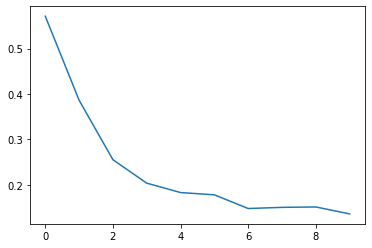

In [22]:
lr = 1e-3
max_epoch = 10
updates_per_epoch = 100

epoch_record = np.zeros([max_epoch,])

check_results()

for epoch_id in range(max_epoch):
    
    loss_record = np.zeros([updates_per_epoch,])
    loss_fkl_record = np.zeros([updates_per_epoch,])
    
    t0 = time()
    
    for step in range(updates_per_epoch):
        
        ind = np.random.choice(n_samples,FLAGS.batch_size)
        
        feed_dict = {learning_rate:lr, LAM:lam}
        feed_dict[input_x] = X[ind]
        feed_dict[input_y] = Y[ind]
        feed_dict[input_t] = T[ind]
        
        ind = np.random.choice(n0,FLAGS.batch_size)
        feed_dict[input_x_t0] = X0[ind]
        ind = np.random.choice(n1,FLAGS.batch_size)
        feed_dict[input_x_t1] = X1[ind]
        
        _,_,loss_fkl_val,loss_y_val = sess.run([train_critic, train_cfr_kl, 
                                        loss_fkl, loss_y], feed_dict)


        for i in range(0):
            
            ind = np.random.choice(n0,FLAGS.batch_size)
            feed_dict[input_x_t0] = X0[ind]
            ind = np.random.choice(n1,FLAGS.batch_size)
            feed_dict[input_x_t1] = X1[ind]
            
            _ = sess.run(train_critic,feed_dict)

        loss_record[step] = loss_y_val + lam*(loss_fkl_val+1.)
        loss_fkl_record[step] = loss_fkl_val
    
    t1 = time()
    
    klm = np.mean(loss_fkl_record)+1
    print([epoch_id+1,np.mean(loss_record),klm,t1-t0])
    epoch_record[epoch_id] = np.mean(loss_record)
    
    check_results()
    
_ = plt.plot(epoch_record)

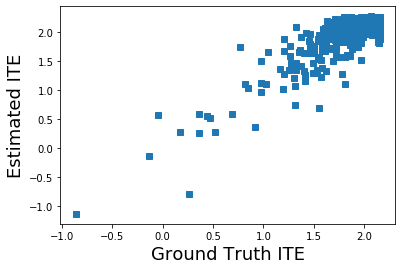

In [23]:
tau_hat = estimate_causal_effect(X).reshape([-1,])
_ = plt.plot(Tau,tau_hat,'s')
_ = plt.xlabel('Ground Truth ITE',fontsize=18)
_ = plt.ylabel('Estimated ITE',fontsize=18)

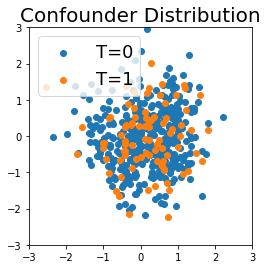

In [24]:
indz = 0

z0_val = tf_eval(phi_x, n0, {input_x: X0})
z1_val = tf_eval(phi_x, n1, {input_x: X1})

_ = _ = plt.figure(figsize=(4,4))

_ = plt.scatter(z0_val[:,0],z0_val[:,1])
_ = plt.scatter(z1_val[:,0],z1_val[:,1])

_ = plt.legend(['T=0','T=1'],fontsize=18)
_ = plt.xlim([-3,3])
_ = plt.ylim([-3,3])
_ = plt.title('Confounder Distribution',fontsize=20)